In [1]:
import numpy as np, os, h5py, pandas as pd
np.set_printoptions(suppress=True)
import tensorflow as tf
from tensorflow import keras as tfk
from tfomics import tfomics 
from tfomics.tfomics import moana, impress, explain
import logomaker
from logomaker import Logo
alphabet = 'ACGT'

from paramiko import SSHClient
from scp import SCPClient

from pairwise_conv_1d import PairwiseConv1D, PairwiseFromStdConv1D
from nearest_neighbor_conv_1d import NearestNeighborConv1D, NearestNeighborFromStdConv1D
from ho_regularizer import HigherOrderKernelRegularizer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2
tfk.backend.clear_session()

In [2]:
# set up ssh and scp connection 
username, hostname = os.getenv('BAMDEV1').split("@")
ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect(hostname=hostname, username=username)
remotehome = ssh.exec_command("echo $HOME")[1].readlines()[0].strip()
scp = SCPClient(ssh.get_transport())
REMOTEDATADIR = os.path.join(remotehome, "projects/higher_order_convolutions", 'data', 'deepbind_encode_chipseq')

In [3]:
tfid = 'GATA1_K562_GATA-1_USC'
print("Downloading data ...")
if not os.path.exists("data.h5"):
    scp.get(remote_path=os.path.join(REMOTEDATADIR, tfid, 'data.h5'))
print("Loading data ...")
data = h5py.File('data.h5', 'r')
x_train = data['X_train'][:]
y_train = data['Y_train'][:]
x_test = data['X_test'][:]
y_test = data['Y_test'][:]
if y_train.ndim == 1:
    y_train = y_train[:, None]
if y_test.ndim == 1:
    y_test = y_test[:, None]
data.close()
!rm data.h5

Loading data ...


## Set up model

In [5]:
def get_model(input_shape, first_layer_conv, name='model', first_layer_activation='relu'):
    x = tfk.layers.Input(shape=input_shape, name='input')
    y = first_layer_conv(x)
    if first_layer_conv.use_bias:
        y = tfk.layers.BatchNormalization()(y)
    y = tfk.layers.Activation(first_layer_activation, name=first_layer_activation)(y)
    y = tfk.layers.MaxPool1D(pool_size=25)(y)
    y = tfk.layers.Dropout(0.1)(y)
    
    # layer 2 - convolution
    l2 = tfk.regularizers.l2(1e-4)
    y = tfk.layers.Conv1D(filters=48,kernel_size=7,strides=1,padding='same',kernel_regularizer=l2, )(y)        
    y = tfk.layers.Activation('relu')(y)
    y = tfk.layers.MaxPool1D(pool_size=4)(y)
    y = tfk.layers.Dropout(0.1)(y)

    # layer 3 - Fully-connected 
    y = tfk.layers.Flatten()(y)
    y = tfk.layers.Dense(96,use_bias=False,kernel_regularizer=l2)(y)      
    y = tfk.layers.BatchNormalization()(y)
    y = tfk.layers.Activation('relu')(y)
    y = tfk.layers.Dropout(0.5)(y)

    # Output layer
    y = tfk.layers.Dense(1, kernel_initializer='glorot_normal',name='logits')(y)
    y = tfk.layers.Activation('sigmoid')(y)

    # create keras model
    model = tfk.Model(inputs=x, outputs=y, name=name)
    
    return model

### Standard convolution

In [6]:
# instantiate model 
input_shape = x_train.shape[1:]
first_layer_activation = 'relu'
diag_regularizer = tfk.regularizers.l1_l2(l2=1e-6)
conv_kwargs = {'padding':'same', 'use_bias':False, 'filters':32, 'kernel_size':21}
first_layer_conv = tfk.layers.Conv1D(kernel_regularizer=diag_regularizer, **conv_kwargs)
stdmodel = get_model(input_shape, first_layer_conv, first_layer_activation=first_layer_activation, name='std_model')

In [7]:
# compile the model - metrics, optimizer, lossfn 
lossfn = tfk.losses.BinaryCrossentropy(name='BCE')
acc = tfk.metrics.BinaryAccuracy(name='Acc')
auroc = tfk.metrics.AUC(curve='ROC', name='AUROC')
aupr = tfk.metrics.AUC(curve='PR', name='AUPR')
metrics = [acc, auroc, aupr]
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)
stdmodel.compile(optimizer, lossfn, metrics)

In [8]:
# train the model 
monitor = 'val_AUROC'
callbacks = [tfk.callbacks.EarlyStopping(monitor=monitor, patience=10, verbose=1, mode='max'),
            tfk.callbacks.ReduceLROnPlateau(monitor=monitor, patience=3, factor=0.2, min_lr=1e-7, mode='max', verbose=1),
            tfk.callbacks.ModelCheckpoint("./%s.hdf5"%stdmodel.name, 
                                          save_best_only=True, save_weights_only=True, monitor=monitor, mode='max')]
stdmodel.fit(x_train, y_train, validation_split=0.2, callbacks=callbacks, epochs=40, batch_size=128)
stdmodel.load_weights("%s.hdf5"%stdmodel.name)

Epoch 1/40
45/45 [==============================] - 10s 68ms/step - loss: 1.8934 - Acc: 0.5114 - AUROC: 0.5061 - AUPR: 0.5093 - val_loss: 1.4404 - val_Acc: 0.5000 - val_AUROC: 0.5399 - val_AUPR: 0.5365
Epoch 2/40
45/45 [==============================] - 2s 47ms/step - loss: 1.4157 - Acc: 0.5110 - AUROC: 0.5107 - AUPR: 0.5021 - val_loss: 1.0816 - val_Acc: 0.5028 - val_AUROC: 0.4892 - val_AUPR: 0.4925
Epoch 3/40
45/45 [==============================] - 2s 48ms/step - loss: 1.0692 - Acc: 0.5068 - AUROC: 0.5076 - AUPR: 0.4919 - val_loss: 0.8687 - val_Acc: 0.5000 - val_AUROC: 0.5515 - val_AUPR: 0.5482
Epoch 4/40
45/45 [==============================] - 2s 47ms/step - loss: 0.8666 - Acc: 0.5151 - AUROC: 0.5199 - AUPR: 0.5152 - val_loss: 0.7957 - val_Acc: 0.5021 - val_AUROC: 0.5917 - val_AUPR: 0.5678
Epoch 5/40
45/45 [==============================] - 2s 48ms/step - loss: 0.7693 - Acc: 0.6028 - AUROC: 0.6333 - AUPR: 0.6117 - val_loss: 0.7840 - val_Acc: 0.7259 - val_AUROC: 0.8013 - val_AUPR: 0

### Pretrained pairwise convolution

In [9]:
stdconv = stdmodel.layers[1]
offdiag_regularizer = tfk.regularizers.l1_l2(l1=5e-3, l2=5e-3)
pconv = PairwiseFromStdConv1D(offdiag_regularizer=offdiag_regularizer, stdconv=stdconv)
p_model_1 = get_model(first_layer_conv=pconv, 
                      first_layer_activation=first_layer_activation, 
                      input_shape=input_shape, 
                      name="p_model_1")

# compile the model - metrics, optimizer, lossfn 
lossfn = tfk.losses.BinaryCrossentropy(name='BCE')
acc = tfk.metrics.BinaryAccuracy(name='Acc')
auroc = tfk.metrics.AUC(curve='ROC', name='AUROC')
aupr = tfk.metrics.AUC(curve='PR', name='AUPR')
metrics = [acc, auroc, aupr]
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)
p_model_1.compile(optimizer, lossfn, metrics)

# train the model 
callbacks = [tfk.callbacks.EarlyStopping(monitor=monitor, patience=10, verbose=1, mode='max'),
            tfk.callbacks.ReduceLROnPlateau(monitor=monitor, patience=3, factor=0.2, min_lr=1e-7, mode='max', verbose=1),
            tfk.callbacks.ModelCheckpoint("./%s.hdf5"%p_model_1.name, 
                                          save_best_only=True, save_weights_only=True, monitor=monitor, mode='max')]
p_model_1.fit(x_train, y_train, validation_split=0.2, callbacks=callbacks, epochs=50, batch_size=128)
p_model_1.load_weights("%s.hdf5"%p_model_1.name)

Epoch 1/50
45/45 [==============================] - 4s 58ms/step - loss: 9.5411 - Acc: 0.5203 - AUROC: 0.5237 - AUPR: 0.5181 - val_loss: 2.8077 - val_Acc: 0.5580 - val_AUROC: 0.5786 - val_AUPR: 0.5732
Epoch 2/50
45/45 [==============================] - 2s 50ms/step - loss: 2.2368 - Acc: 0.5247 - AUROC: 0.5378 - AUPR: 0.5423 - val_loss: 1.5898 - val_Acc: 0.6615 - val_AUROC: 0.7337 - val_AUPR: 0.7536
Epoch 3/50
45/45 [==============================] - 2s 50ms/step - loss: 1.5551 - Acc: 0.6683 - AUROC: 0.7274 - AUPR: 0.7388 - val_loss: 1.5834 - val_Acc: 0.7734 - val_AUROC: 0.8601 - val_AUPR: 0.8752
Epoch 4/50
45/45 [==============================] - 2s 51ms/step - loss: 1.3302 - Acc: 0.8262 - AUROC: 0.9022 - AUPR: 0.9072 - val_loss: 1.4457 - val_Acc: 0.7895 - val_AUROC: 0.8807 - val_AUPR: 0.8951
Epoch 5/50
45/45 [==============================] - 2s 51ms/step - loss: 1.2134 - Acc: 0.8450 - AUROC: 0.9183 - AUPR: 0.9240 - val_loss: 1.3760 - val_Acc: 0.8112 - val_AUROC: 0.8838 - val_AUPR: 0.

### Pairwise convolution without pretraining 

In [10]:
kernel_regularizer = HigherOrderKernelRegularizer(
                                diag_regularizer=diag_regularizer, 
                                offdiag_regularizer=offdiag_regularizer
                                                )
pconv = PairwiseConv1D(kernel_regularizer=kernel_regularizer, **conv_kwargs)
p_model_2 = get_model(first_layer_conv=pconv, 
                      first_layer_activation=first_layer_activation, 
                      input_shape=input_shape, 
                      name="p_model_2") 

# compile the model - metrics, optimizer, lossfn 
lossfn = tfk.losses.BinaryCrossentropy(name='BCE')
acc = tfk.metrics.BinaryAccuracy(name='Acc')
auroc = tfk.metrics.AUC(curve='ROC', name='AUROC')
aupr = tfk.metrics.AUC(curve='PR', name='AUPR')
metrics = [acc, auroc, aupr]
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)
p_model_2.compile(optimizer, lossfn, metrics)

# train the model 
callbacks = [tfk.callbacks.EarlyStopping(monitor=monitor, patience=10, verbose=1, mode='max'),
            tfk.callbacks.ReduceLROnPlateau(monitor=monitor, patience=3, factor=0.2, min_lr=1e-7, mode='max', verbose=1),
            tfk.callbacks.ModelCheckpoint("./%s.hdf5"%p_model_2.name, 
                                          save_best_only=True, save_weights_only=True, monitor=monitor, mode='max')]
p_model_2.fit(x_train, y_train, validation_split=0.2, callbacks=callbacks, epochs=40, batch_size=128)
p_model_2.load_weights("%s.hdf5"%p_model_2.name)

Epoch 1/40
45/45 [==============================] - 4s 62ms/step - loss: 11.5838 - Acc: 0.5137 - AUROC: 0.5124 - AUPR: 0.5052 - val_loss: 3.8054 - val_Acc: 0.5329 - val_AUROC: 0.5645 - val_AUPR: 0.5543
Epoch 2/40
45/45 [==============================] - 2s 54ms/step - loss: 3.3932 - Acc: 0.4985 - AUROC: 0.5065 - AUPR: 0.5188 - val_loss: 2.4160 - val_Acc: 0.5028 - val_AUROC: 0.5636 - val_AUPR: 0.5595
Epoch 3/40
45/45 [==============================] - 2s 54ms/step - loss: 2.3247 - Acc: 0.5230 - AUROC: 0.5220 - AUPR: 0.5082 - val_loss: 1.8430 - val_Acc: 0.5063 - val_AUROC: 0.5310 - val_AUPR: 0.5478
Epoch 4/40
45/45 [==============================] - 2s 55ms/step - loss: 1.8041 - Acc: 0.5208 - AUROC: 0.5195 - AUPR: 0.5163 - val_loss: 1.5022 - val_Acc: 0.5000 - val_AUROC: 0.5795 - val_AUPR: 0.5751
Epoch 5/40
45/45 [==============================] - 2s 54ms/step - loss: 1.4838 - Acc: 0.5471 - AUROC: 0.5499 - AUPR: 0.5391 - val_loss: 1.3790 - val_Acc: 0.6629 - val_AUROC: 0.7795 - val_AUPR: 0

45/45 [==============================] - 2s 55ms/step - loss: 0.2932 - Acc: 0.9543 - AUROC: 0.9868 - AUPR: 0.9893 - val_loss: 0.5885 - val_Acc: 0.8252 - val_AUROC: 0.9006 - val_AUPR: 0.9134
Epoch 40/40
45/45 [==============================] - 2s 55ms/step - loss: 0.2850 - Acc: 0.9576 - AUROC: 0.9889 - AUPR: 0.9906 - val_loss: 0.5881 - val_Acc: 0.8245 - val_AUROC: 0.9006 - val_AUPR: 0.9134

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-07.


In [11]:
std_metrics = stdmodel.evaluate(x_test, y_test.astype(np.float32), return_dict=False)
p1_metrics = p_model_1.evaluate(x_test, y_test.astype(np.float32), return_dict=False)
p2_metrics = p_model_2.evaluate(x_test, y_test.astype(np.float32), return_dict=False)
data = np.vstack([std_metrics, p1_metrics, p2_metrics])
index=pd.Index(['std.', 'pairwise(transferred)','pairwise'],name='Model')
columns = stdmodel.metrics_names
pd.DataFrame(data=data, 
             index=index,
             columns=columns,
             )

32/32 [==============================] - 1s 25ms/step - loss: 0.4036 - Acc: 0.9040 - AUROC: 0.9635 - AUPR: 0.9666


,loss,Acc,AUROC,AUPR
Model,,,,
std.,0.372852,0.902,0.960324,0.962320
pairwise(transferred),0.404322,0.907,0.969388,0.971832
pairwise,0.403640,0.904,0.963492,0.966611


In [12]:
def visualize_filters(W, num_rows, num_cols, alphabet='ACGT', title=""):
    n_filters, filter_len = W.shape[:2]
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 1.2*num_rows))
    
    for i, w in enumerate(W):
        ax[int(i/num_cols), i%num_cols].set_xticks([])
        ax[int(i/num_cols), i%num_cols].set_yticks([])
        I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
        logo = logo = I*w
        logo = Logo(
            pd.DataFrame(data=logo, columns=list(alphabet), index=list(range(filter_len))), 
            ax=ax[int(i/num_cols), i%num_cols]
                    )
        ax[int(i/num_cols), i%num_cols].set_ylabel(i)
        ax[int(i/num_cols), i%num_cols].set_ylim(0, 2)
    fig.suptitle(title, fontsize=15)
    fig.tight_layout()

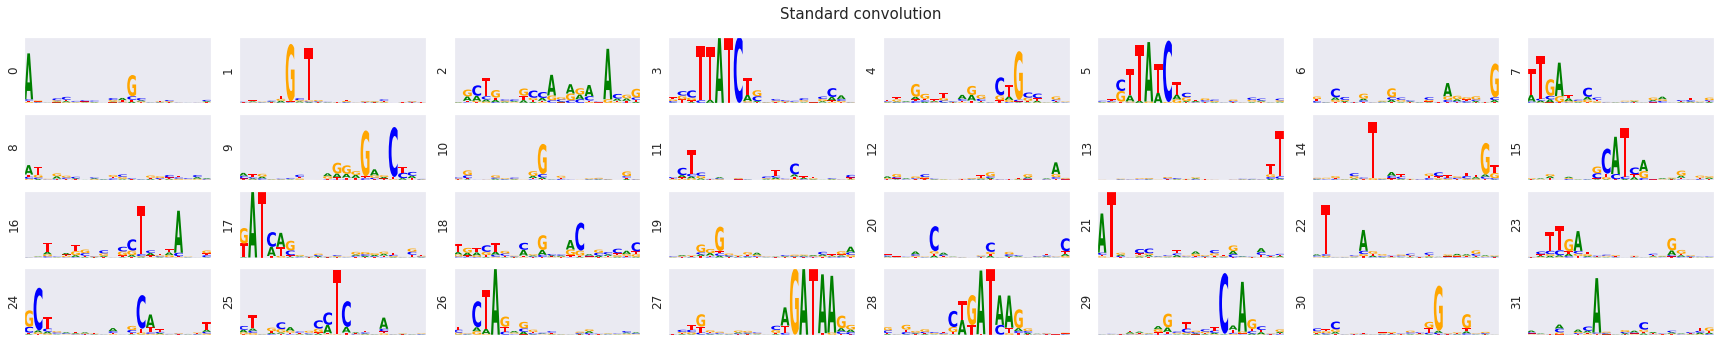

In [13]:
idx = np.random.randint(0, x_test.shape[0], (500,))
threshold = 0.5
num_rows, num_cols = 4, 8
for i, ell in enumerate(stdmodel.layers):
    if ell == stdmodel.get_layer(first_layer_activation):
        layer = i
        break

W_std = moana.filter_activations(x_test[idx], stdmodel, layer=layer, window=20, threshold=threshold)
#W_std = tf.transpose(stdmodel.layers[1].kernel, (2, 0, ))
visualize_filters(W_std, num_rows, num_cols, title="Standard convolution")

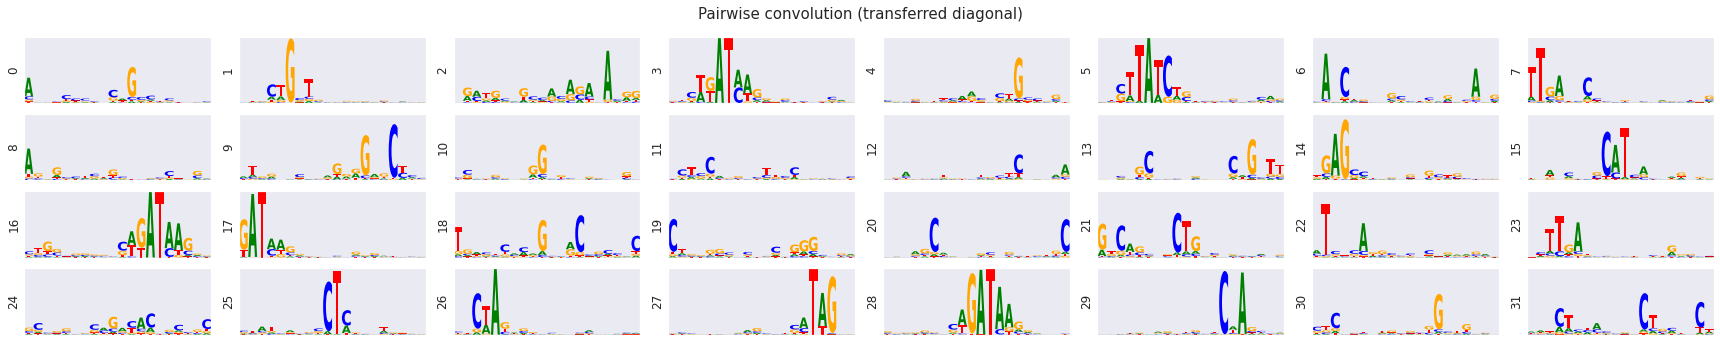

In [14]:
W_p1 = moana.filter_activations(x_test[idx], p_model_1, layer=layer, window=20, threshold=threshold)
visualize_filters(W_p1, num_rows, num_cols, title="Pairwise convolution (transferred diagonal)")

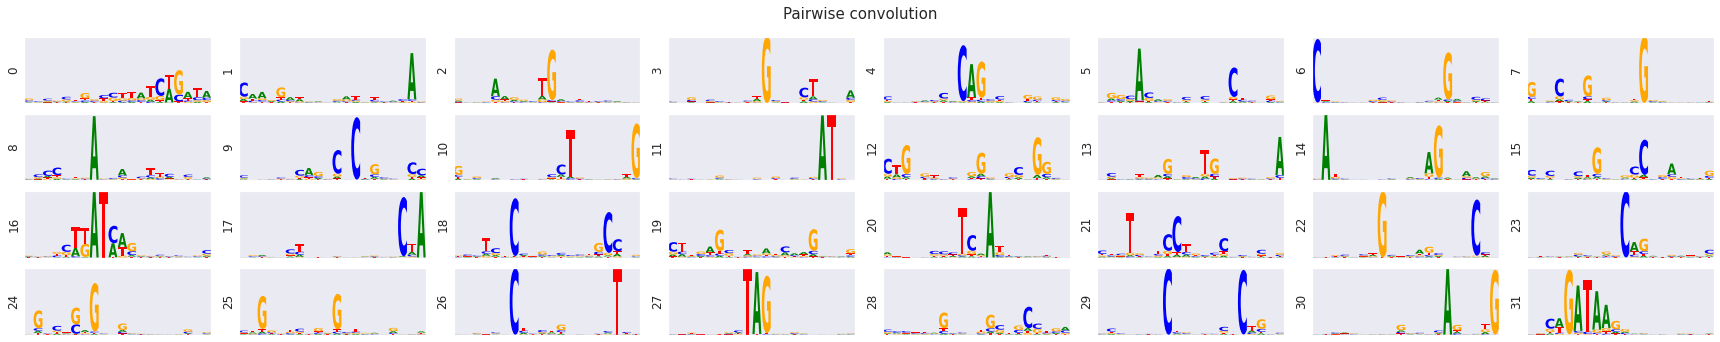

In [15]:
W_p2 = moana.filter_activations(x_test[idx], p_model_2, layer=layer, window=20, threshold=threshold)
visualize_filters(W_p2, num_rows, num_cols, title="Pairwise convolution")

In [19]:
pos_idx = np.where(y_test == 1.)[0]
X = x_test[pos_idx]

In [20]:
std_explainer = explain.Explainer(model=stdmodel, class_index=0)
p1_explainer = explain.Explainer(model=p_model_1, class_index=0)
p2_explainer = explain.Explainer(model=p_model_2, class_index=0)

In [21]:
print("Get saliency scores...")
std_saliency = std_explainer.saliency_maps(X)
p1_saliency = p1_explainer.saliency_maps(X)
p2_saliency = p2_explainer.saliency_maps(X)

print("Get integrated gradient scores...")
std_ig = std_explainer.integrated_grad(X)
p1_ig = p1_explainer.integrated_grad(X)
p2_ig = p2_explainer.integrated_grad(X)

print("Get smoothgrad scores...")
std_sg = std_explainer.smoothgrad(X)
p1_sg = p1_explainer.smoothgrad(X)
p2_sg = p2_explainer.smoothgrad(X)

Get saliency scores...
Get integrated gradient scores...
Get smoothgrad scores...


In [25]:
idx = np.random.choice(np.arange(len(X)))

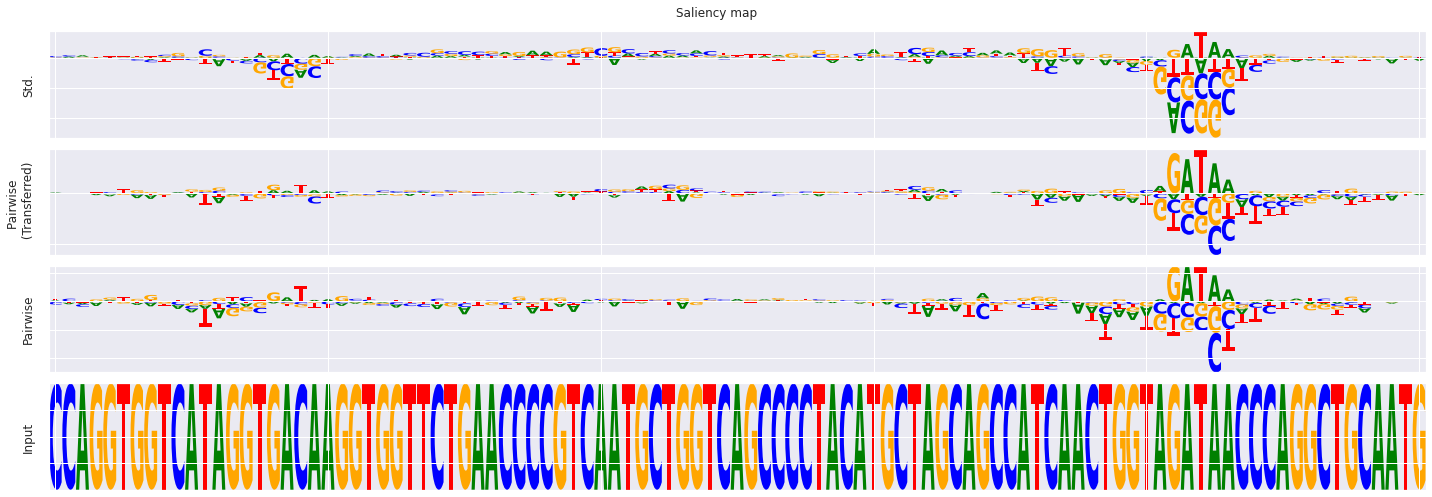

In [28]:
fig, ax = plt.subplots(4, 1, figsize=(20, 7))
for i in range(len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

ax[0].set_ylabel("Std.")
ax[1].set_ylabel("Pairwise \n (Transferred)")
ax[2].set_ylabel("Pairwise")
ax[3].set_ylabel("Input")

Logo(
    df=pd.DataFrame(std_saliency[idx], columns=list('ACGT')),
    ax=ax[0]
    )
Logo(
    df=pd.DataFrame(p1_saliency[idx], columns=list('ACGT')),
    ax=ax[1]
    )
Logo(
    df=pd.DataFrame(p2_saliency[idx], columns=list('ACGT')),
    ax=ax[2]
    )
Logo(
    df=pd.DataFrame(X[idx], columns=list('ACGT')),
    ax=ax[3]
    )

fig.suptitle('Saliency map')
fig.tight_layout()

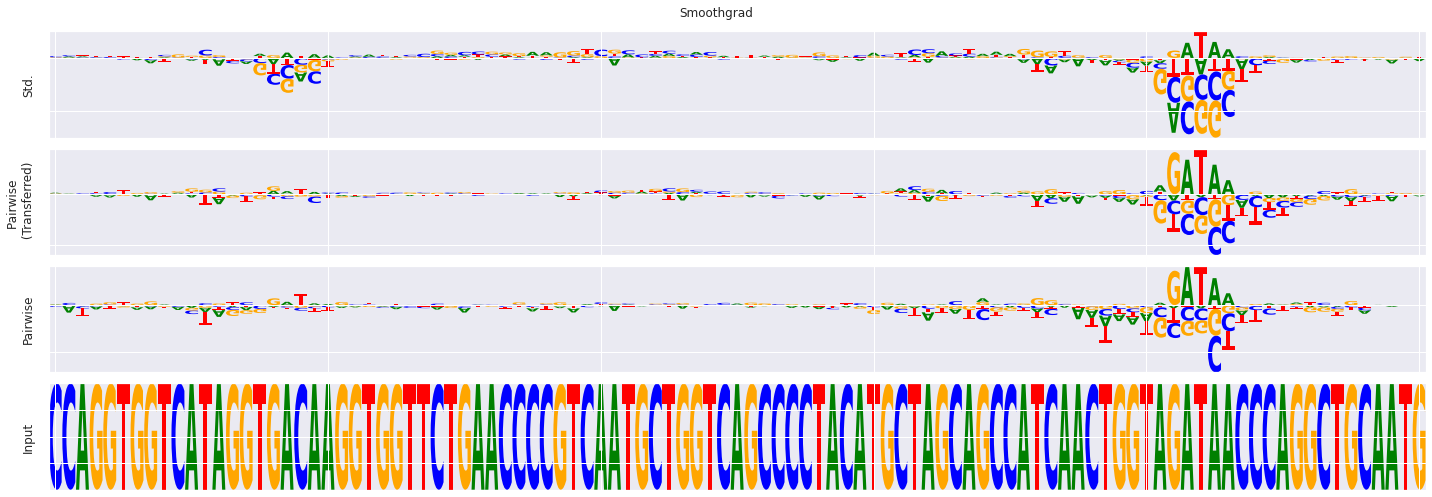

In [30]:
fig, ax = plt.subplots(4, 1, figsize=(20, 7))
for i in range(len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

ax[0].set_ylabel("Std.")
ax[1].set_ylabel("Pairwise \n (Transferred)")
ax[2].set_ylabel("Pairwise")
ax[3].set_ylabel("Input")
Logo(
    df=pd.DataFrame(std_sg[idx], columns=list('ACGT')),
    ax=ax[0]
    )
Logo(
    df=pd.DataFrame(p1_sg[idx], columns=list('ACGT')),
    ax=ax[1]
    )
Logo(
    df=pd.DataFrame(p2_sg[idx], columns=list('ACGT')),
    ax=ax[2]
    )
Logo(
    df=pd.DataFrame(X[idx], columns=list('ACGT')),
    ax=ax[3]
    )

fig.suptitle('Smoothgrad')
fig.tight_layout()

In [168]:
xs=list(x_train.argmax(2))
xs=["".join(pd.Series(x).map({i:a for i, a in enumerate(alphabet)}).values) for x in xs]

In [ ]:
motif1 = 'TGACTCA'
motif2 = 'TGAGTCA'
pos_idx = np.where(y_train[:,0] == 1.)[0]
neg_idx = np.where(y_train[:,0] != 1.)[0]

In [189]:
I = []
for idx in pos_idx:
    seq = xs[idx]
    i1 = seq.find(motif1)
    i2 = seq.find(motif2)
    print(i1, i2)

-1 -1
59 47
25 -1
42 -1
-1 45
49 37
-1 56
32 -1
-1 -1
-1 31
-1 57
13 -1
56 -1
-1 56
-1 -1
-1 -1
-1 52
49 -1
30 -1
40 29
-1 -1
51 -1
38 -1
54 -1
35 23
58 -1
-1 -1
52 -1
-1 4
-1 36
-1 -1
37 -1
38 -1
19 -1
-1 -1
-1 -1
55 -1
-1 62
-1 42
-1 10
-1 52
63 -1
-1 37
-1 34
-1 39
45 -1
41 -1
-1 -1
-1 68
-1 12
-1 53
-1 64
-1 49
-1 46
-1 -1
-1 -1
51 -1
38 -1
-1 -1
-1 -1
-1 47
63 -1
-1 -1
-1 74
-1 -1
-1 38
-1 33
11 -1
-1 41
-1 36
60 -1
30 -1
-1 29
28 86
77 -1
44 -1
49 -1
-1 39
-1 36
37 -1
63 -1
24 69
36 -1
-1 -1
-1 -1
-1 52
42 -1
-1 38
50 -1
92 37
43 -1
51 -1
-1 71
-1 40
41 21
61 -1
-1 -1
-1 33
-1 -1
-1 -1
19 -1
-1 56
-1 60
-1 50
31 51
-1 58
58 -1
49 -1
-1 -1
-1 -1
46 -1
-1 50
21 -1
-1 33
-1 45
-1 62
-1 -1
-1 -1
-1 -1
42 -1
-1 -1
60 -1
37 -1
-1 62
-1 46
48 -1
47 29
56 -1
-1 68
-1 60
-1 53
62 -1
-1 -1
-1 -1
-1 33
-1 33
26 -1
53 -1
27 -1
51 -1
57 -1
-1 74
-1 -1
-1 -1
46 -1
-1 -1
-1 21
-1 51
-1 47
90 -1
-1 52
84 -1
60 35
-1 -1
30 -1
63 -1
37 -1
40 -1
-1 35
58 43
18 -1
30 -1
34 -1
-1 50
-1 -1
75 63
54 -1

-1 -1
93 -1
-1 40
-1 -1
-1 -1
-1 -1
-1 -1
43 -1
-1 33
-1 61
-1 40
-1 -1
-1 35
-1 -1
-1 -1
-1 -1
36 -1
-1 -1
-1 64
-1 8
60 -1
53 -1
-1 47
80 -1
-1 -1
-1 -1
-1 45
-1 74
38 -1
62 -1
-1 -1
37 -1
77 -1
-1 44
-1 42
-1 62
15 -1
-1 57
-1 56
-1 -1
-1 24
39 -1
-1 66
-1 -1
-1 -1
-1 -1
-1 27
63 -1
-1 35
-1 -1
50 -1
-1 -1
-1 48
63 -1
41 -1
29 -1
-1 -1
-1 -1
-1 -1
20 -1
-1 -1
-1 51
-1 -1
-1 -1
-1 -1
73 -1
-1 36
49 -1
-1 24
-1 -1
25 -1
-1 -1
-1 -1
-1 -1
-1 29
-1 38
-1 2
-1 -1
-1 -1
54 -1
-1 -1
-1 -1
-1 47
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
62 -1
16 -1
30 -1
44 -1
-1 58
47 63
-1 56
-1 -1
-1 -1
55 -1
23 -1
-1 0
-1 -1
32 -1
-1 -1
-1 40
18 -1
36 -1
-1 31
-1 -1
-1 29
-1 -1
-1 -1
-1 -1
53 -1
63 -1
-1 43
36 -1
39 -1
-1 60
-1 -1
-1 80
-1 -1
-1 48
36 -1
34 -1
-1 -1
-1 -1
38 -1
-1 34
-1 29
-1 35
43 -1
-1 -1
21 -1
48 -1
29 -1
-1 47
-1 -1
-1 32
31 -1
34 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 24
45 -1
56 -1
-1 -1
67 -1
-1 47
-1 62
33 -1
-1 -1
-1 55
-1 74
62 -1
34 -1
-1 50
-1 56
42 -1
28 -1
-1 -1
-1 6
-1 37
-1 -1
-1 -1
36 -1
-1

43 -1
-1 -1
-1 -1
44 -1
-1 45
-1 38
-1 -1
-1 -1
-1 -1
50 -1
-1 66
-1 -1
-1 26
86 -1
-1 42
-1 -1
-1 -1
-1 -1
30 -1
70 26
37 -1
-1 -1
-1 -1
-1 34
-1 49
54 -1
-1 -1
59 -1
-1 44
45 -1
-1 -1
41 -1
-1 82
-1 -1
60 -1
-1 56
-1 -1
-1 -1
-1 -1
-1 41
-1 -1
49 -1
26 -1
47 -1
-1 63
-1 37
-1 -1
25 -1
-1 63
-1 -1
-1 -1
63 -1
41 -1
-1 68
-1 -1
40 -1
-1 -1
-1 -1
65 -1
-1 58
28 -1
-1 53
43 -1
43 -1
-1 -1
-1 -1
-1 -1
26 -1
-1 -1
-1 66
16 -1
39 -1
-1 -1
-1 53
-1 49
-1 65
20 -1
14 -1
-1 -1
-1 -1
45 -1
-1 53
-1 -1
57 -1
-1 -1
-1 47
50 -1
-1 30
46 -1
35 -1
-1 -1
-1 -1
36 -1
-1 85
-1 -1
-1 43
41 -1
-1 70
49 -1
47 15
58 -1
-1 46
-1 32
-1 36
-1 32
-1 -1
-1 42
51 -1
50 -1
-1 34
-1 -1
40 -1
36 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 46
-1 -1
-1 -1
-1 54
-1 -1
45 -1
-1 -1
44 -1
-1 18
-1 -1
-1 -1
40 -1
-1 -1
-1 -1
47 -1
62 -1
-1 47
-1 40
-1 -1
-1 -1
27 -1
-1 58
-1 28
-1 47
47 62
51 -1
-1 -1
55 -1
53 -1
-1 29
80 -1
-1 -1
-1 -1
-1 -1
41 -1
-1 -1
67 -1
-1 45
-1 -1
-1 42
-1 25
43 -1
-1 -1
-1 -1
-1 88
-1 -1
68 -1
-1 45
-1 -

-1 -1
-1 -1
-1 -1
57 -1
-1 54
-1 -1
59 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
72 31
29 -1
22 -1
-1 -1
-1 -1
30 -1
52 -1
14 -1
-1 -1
57 -1
50 -1
-1 -1
-1 37
-1 -1
-1 -1
-1 53
42 -1
71 -1
44 -1
67 -1
-1 -1
-1 -1
-1 -1
-1 30
-1 -1
-1 -1
-1 -1
-1 34
-1 -1
-1 -1
-1 -1
-1 -1
-1 56
64 -1
-1 47
46 58
46 68
-1 82
-1 -1
-1 -1
-1 -1
46 -1
-1 -1
-1 75
-1 -1
48 -1
-1 55
-1 58
-1 36
-1 -1
61 39
-1 42
-1 -1
48 -1
59 -1
55 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 44
-1 -1
-1 -1
30 -1
50 -1
58 -1
44 -1
40 -1
-1 -1
-1 -1
-1 -1
-1 35
-1 -1
17 -1
20 -1
60 -1
-1 -1
-1 -1
-1 72
46 -1
-1 10
27 -1
-1 54
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
41 -1
-1 -1
-1 -1
69 -1
-1 36
33 -1
58 82
-1 -1
-1 -1
36 -1
-1 -1
-1 -1
-1 48
-1 -1
42 -1
78 -1
-1 -1
31 -1
60 -1
-1 -1
38 -1
-1 -1
-1 -1
61 -1
-1 -1
49 -1
-1 -1
57 -1
-1 -1
-1 -1
50 -1
-1 41
-1 39
-1 -1
61 -1
53 -1
-1 -1
58 -1
-1 -1
41 -1
-1 30
-1 55
-1 -1
-1 -1
-1 37
-1 73
50 -1
38 -1
-1 -1
-1 -1
-1 -1
-1 -1
43 -1
-1 -1
-1 69
21 86
-1 41
-1 -1
-1 33
-1 43
-1 -1
-1 -1
-1 -

43 -1
37 -1
-1 -1
37 -1
-1 50
-1 -1
42 -1
-1 43
33 -1
-1 49
-1 -1
-1 -1
-1 48
-1 39
-1 60
64 -1
45 8
-1 -1
-1 -1
-1 -1
-1 36
-1 34
89 20
-1 63
23 -1
60 -1
-1 53
50 -1
27 -1
-1 -1
-1 53
33 -1
-1 43
81 -1
-1 59
-1 -1
-1 42
-1 -1
-1 61
-1 -1
-1 -1
-1 -1
-1 -1
30 -1
-1 -1
-1 -1
-1 -1
-1 33
49 -1
-1 -1
-1 -1
-1 -1
-1 39
83 -1
-1 82
-1 -1
-1 -1
-1 -1
67 -1
50 -1
45 -1
-1 39
60 -1
-1 -1
61 -1
-1 -1
-1 -1
-1 65
-1 50
-1 49
-1 -1
-1 -1
-1 -1
-1 58
-1 80
-1 39
10 -1
-1 32
-1 -1
45 -1
-1 -1
-1 -1
-1 -1
-1 43
-1 -1
80 -1
17 -1
-1 -1
25 -1
-1 39
-1 -1
-1 -1
-1 -1
-1 18
-1 -1
-1 12
-1 -1
51 -1
-1 40
-1 -1
40 -1
-1 -1
-1 60
-1 37
-1 -1
-1 30
-1 -1
-1 41
65 -1
-1 47
-1 30
57 -1
-1 -1
-1 -1
45 -1
-1 54
-1 -1
43 -1
-1 49
-1 -1
-1 -1
-1 -1
-1 -1
72 -1
-1 52
43 -1
-1 -1
43 -1
19 -1
-1 -1
-1 -1
48 -1
-1 -1
18 -1
-1 57
-1 36
-1 47
-1 -1
-1 -1
58 -1
-1 -1
-1 -1
-1 -1
-1 -1
0 -1
-1 53
-1 -1
-1 -1
-1 48
-1 -1
-1 30
29 -1
52 -1
-1 -1
-1 34
24 -1
52 -1
-1 74
39 -1
-1 -1
-1 56
-1 -1
-1 51
41 -1
39 -1
-1 45
-1 -1


-1 -1
-1 33
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 35
-1 -1
-1 31
-1 -1
-1 54
-1 -1
-1 31
-1 -1
54 -1
-1 48
-1 31
-1 53
-1 -1
72 -1
-1 -1
-1 46
-1 42
-1 -1
-1 29
-1 39
52 -1
60 -1
19 -1
-1 56
-1 48
-1 -1
-1 -1
-1 -1
49 -1
44 -1
-1 75
-1 -1
-1 -1
-1 -1
-1 37
-1 -1
-1 -1
44 -1
44 -1
-1 -1
-1 71
35 -1
-1 38
-1 -1
-1 -1
53 -1
-1 36
-1 -1
-1 -1
36 49
-1 51
-1 -1
8 -1
-1 12
-1 51
48 -1
61 -1
-1 32
-1 -1
-1 39
34 -1
-1 -1
46 -1
-1 -1
-1 50
54 -1
28 -1
60 -1
67 -1
-1 -1
-1 46
-1 -1
-1 -1
-1 21
35 -1
-1 -1
-1 -1
33 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
65 -1
-1 -1
-1 41
-1 -1
-1 -1
38 -1
-1 65
-1 -1
23 42
-1 41
17 -1
-1 -1
-1 -1
-1 -1
-1 -1
36 -1
15 58
-1 -1
-1 -1
-1 61
74 -1
-1 -1
-1 -1
-1 -1
-1 -1
28 -1
-1 54
-1 37
33 -1
-1 2
-1 -1
-1 43
16 -1
49 -1
66 -1
-1 -1
-1 -1
46 -1
-1 -1
-1 -1
-1 -1
42 -1
65 46
-1 -1
-1 -1
-1 -1
-1 36
-1 -1
-1 51
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
23 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 32
-1 22
40 -1
-1 85
57 -1
-1 -1
-1 53
-1 -1
-1 61


-1 -1
-1 49
-1 -1
-1 -1
-1 -1
-1 -1
44 -1
-1 36
40 -1
-1 19
-1 23
-1 -1
51 -1
-1 25
-1 -1
-1 -1
-1 -1
-1 -1
-1 61
-1 -1
-1 -1
53 -1
58 -1
24 -1
-1 58
45 -1
48 -1
-1 -1
-1 63
-1 -1
-1 -1
-1 -1
-1 -1
-1 39
-1 -1
-1 56
-1 -1
14 -1
-1 -1
-1 -1
-1 37
-1 -1
-1 -1
-1 66
-1 -1
-1 33
-1 -1
-1 -1
-1 -1
-1 -1
64 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 89
6 -1
-1 -1
-1 49
74 -1
-1 44
-1 36
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
43 -1
-1 55
23 -1
-1 -1
-1 -1
-1 -1
-1 14
32 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 31
-1 -1
-1 27
-1 37
-1 38
-1 -1
-1 -1
-1 -1
-1 -1
60 -1
-1 25
-1 50
-1 36
-1 -1
18 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 81
-1 -1
-1 -1
-1 -1
-1 -1
54 -1
-1 -1
67 -1
57 -1
-1 -1
-1 60
-1 41
-1 -1
-1 -1
43 -1
-1 -1
-1 -1
-1 35
-1 56
-1 -1
-1 -1
47 -1
-1 -1
-1 -1
24 -1
-1 -1
-1 35
85 -1
-1 39
-1 48
-1 -1
59 -1
-1 21
-1 49
-1 38
-1 -1
-1 -1
-1 -1
-1 -1
-1 77
-1 -1
71 -1
-1 -1
-1 -1
-1 52
-1 -1
-1 -1
-1 50
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
63 -1
50 -1
-1 -1
-1 40
-1 44
-1 -1
45 -1
-1 -1
-1 53
-1 -1
64 -1
-1 -1
-1 37

34 -1
-1 -1
44 -1
-1 -1
-1 -1
-1 -1
29 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 67
-1 -1
-1 -1
-1 47
61 -1
-1 -1
-1 -1
-1 -1
-1 -1
61 22
-1 -1
-1 19
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
58 -1
-1 -1
-1 -1
-1 66
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 34
-1 -1
-1 -1
27 -1
37 -1
-1 52
-1 -1
-1 -1
30 -1
-1 -1
-1 -1
-1 -1
-1 -1
34 -1
-1 -1
-1 50
79 -1
-1 -1
-1 69
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 55
59 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 37
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
63 -1
-1 -1
-1 -1
20 -1
-1 -1
-1 44
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 57
-1 -1
-1 -1
-1 -1
-1 -1
-1 31
-1 -1
-1 81
-1 16
59 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 39
39 -1
28 -1
-1 -1
-1 28
-1 81
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
41 -1
-1 41
-1 -1
-1 -1
-1 27
-1 42
-1 -1
-1 51
-1 -1
-1 37
-1 -1
-1 71
-1 -1
-1 13
-1 50
-1 -1
-1 -1
-1 -1
29 -1
-1 -1
-1 -1
-1 -1
47 -1
-1 -1
-1 -1
-1 -1
-1 41
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 29
-1 51
-1 -1
-1 -1
-1 24
-1 62
48 -1
6 -1

-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 33
-1 17
-1 -1
-1 -1
-1 -1
-1 -1
61 -1
-1 46
-1 -1
58 -1
-1 26
-1 62
-1 -1
49 -1
-1 -1
-1 -1
63 -1
-1 49
-1 -1
21 -1
49 -1
-1 -1
6 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
48 -1
-1 52
65 -1
-1 -1
-1 -1
63 -1
-1 13
-1 -1
-1 -1
55 -1
31 -1
-1 -1
-1 -1
15 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
43 -1
-1 60
-1 -1
30 -1
-1 28
-1 -1
-1 40
-1 -1
-1 -1
44 -1
61 -1
-1 -1
-1 -1
-1 -1
-1 -1
63 -1
-1 -1
-1 52
-1 54
-1 88
-1 51
-1 -1
77 -1
-1 -1
-1 58
-1 -1
-1 -1
-1 -1
57 -1
-1 -1
-1 42
-1 -1
-1 -1
6 -1
59 -1
-1 -1
71 33
-1 45
-1 30
-1 61
-1 -1
-1 78
72 -1
-1 -1
-1 -1
42 -1
28 -1
15 -1
-1 -1
-1 -1
-1 -1
-1 -1
63 -1
-1 -1
55 -1
-1 -1
-1 37
-1 -1
-1 -1
-1 -1
32 -1
-1 -1
-1 61
13 -1
-1 -1
-1 -1
-1 -1
10 -1
-1 -1
-1 -1
-1 -1
-1 50
-1 73
-1 -1
23 -1
-1 -1
-1 -1
51 -1
-1 -1
-1 -1
53 -1
-1 37
-1 45
-1 -1
26 -1
31 -1
-1 -1
-1 -1
-1 -1
-1 -1
38 -1
32 -1
-1 -1
24 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
38 -1
-1 -1
-1 42
-1 -1
53 -1
-1 82
-1 -1
-1 -1
-1 -1
-1 -1
-1 65
-1 -1


53 -1
-1 74
-1 -1
-1 -1
-1 -1
65 -1
-1 43
-1 -1
-1 5
-1 54
-1 -1
-1 -1
-1 -1
-1 -1
-1 47
37 -1
-1 -1
-1 25
-1 -1
-1 -1
-1 -1
-1 -1
-1 28
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 13
-1 -1
-1 -1
-1 -1
-1 -1
47 -1
-1 -1
-1 57
-1 -1
16 -1
-1 -1
-1 -1
-1 -1
-1 39
-1 -1
-1 38
-1 -1
-1 -1
-1 -1
-1 -1
-1 53
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 61
-1 -1
-1 -1
-1 -1
-1 -1
-1 65
-1 -1
-1 59
-1 -1
-1 -1
-1 -1
-1 -1
-1 65
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 52
-1 -1
57 -1
-1 -1
-1 9
48 -1
54 -1
-1 -1
49 -1
39 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
39 -1
31 -1
-1 -1
52 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 39
-1 -1
32 -1
-1 53
-1 -1
-1 -1
-1 55
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
63 -1
-1 -1
58 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 29
-1 58
-1 -1
40 -1
32 -1
-1 -1
-1 11
-1 -1
-1 -1
79 -1
-1 -1
-1 -1
-1 -1
54 -1
68 0
-1 -1
-1 56
-1 -1
-1 -1
-1 56
59 -1
-1 -1
51 -1
-1 -1
61 -1
-1 -1
-1 -1
-1 -1
-1 -1
33 -1
-1 -1
-1 17
-1 -1
-1 -1
-1 -1
41 -1
-1 -1
-1 -1
-1 -1
56 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 19
-1 -1
18 -1
-1 -1
-1 -1
-

-1 42
31 -1
-1 35
-1 61
-1 -1
33 -1
-1 14
-1 -1
-1 -1
-1 -1
-1 53
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
48 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 38
-1 -1
-1 -1
-1 33
37 -1
-1 -1
56 -1
-1 -1
-1 -1
-1 -1
56 -1
-1 42
-1 -1
-1 -1
-1 -1
-1 -1
40 -1
-1 -1
-1 -1
-1 50
9 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 31
-1 -1
-1 -1
-1 -1
-1 33
-1 -1
-1 -1
-1 -1
38 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
33 -1
-1 -1
-1 -1
-1 54
-1 -1
-1 -1
-1 -1
59 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 39
-1 -1
-1 -1
-1 -1
-1 33
23 -1
-1 -1
-1 25
-1 -1
-1 -1
51 -1
-1 -1
-1 -1
-1 -1
60 -1
55 -1
45 -1
63 -1
-1 -1
65 -1
-1 -1
-1 -1
-1 22
50 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 13
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
80 -1
-1 -1
-1 36
-1 -1
-1 60
-1 -1
39 -1
-1 -1
50 -1
-1 -1
-1 21
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
32 -1
-1 -1
-1 -1
-1 -1
-1 -1
24 -1
65 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 57
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
57 -1

-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 36
-1 -1
-1 -1
58 -1
-1 -1
54 -1
-1 32
-1 -1
-1 -1
-1 -1
-1 -1
63 -1
38 -1
-1 -1
65 -1
-1 -1
-1 -1
19 -1
-1 -1
-1 5
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
42 -1
-1 -1
34 -1
-1 -1
-1 -1
52 -1
-1 47
-1 -1
-1 51
-1 -1
-1 14
53 -1
-1 -1
26 -1
-1 -1
-1 -1
4 -1
-1 -1
61 -1
64 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
61 -1
-1 43
-1 -1
-1 -1
-1 -1
49 -1
-1 -1
-1 16
-1 -1
43 -1
-1 -1
-1 -1
-1 -1
-1 -1
58 -1
-1 -1
-1 -1
-1 48
48 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
43 -1
-1 30
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 39
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
36 -1
-1 -1
-1 51
-1 19
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 57
-1 -1
26 -1
-1 -1
62 -1
-1 -1
-1 -1
-1 -1
-1 -1
19 -1
46 -1
40 -1
-1 -1
-1 -1
-1 78
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 11
-1 -1
-1 -1
-1 2
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 55
-1 75
-1 -1
-1 -1
-1 -1
-1 -1
58 -1
-1 -1
-1 -1
-1 -1
60 -1
-1 -1
-1 -1
-1 59
60 -1
53 -1
28 -1
-1 -1
-

-1 60
-1 -1
-1 -1
-1 -1
33 -1
73 35
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 67
-1 -1
-1 -1
57 -1
-1 -1
-1 -1
-1 41
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 9
-1 -1
-1 -1
-1 -1
-1 -1
-1 31
38 -1
-1 -1
-1 -1
-1 -1
-1 44
-1 -1
33 -1
37 -1
-1 -1
-1 -1
-1 39
-1 42
-1 -1
-1 -1
-1 -1
31 -1
-1 -1
-1 -1
-1 -1
-1 45
-1 21
-1 21
-1 -1
60 -1
-1 45
47 -1
-1 66
30 61
33 -1
-1 -1
60 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
34 -1
-1 -1
-1 -1
-1 39
-1 -1
-1 -1
-1 -1
-1 -1
58 -1
-1 -1
-1 43
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 49
-1 45
-1 -1
51 -1
-1 -1
56 -1
-1 -1
-1 -1
-1 -1
-1 61
-1 -1
-1 29
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
43 -1
49 -1
-1 -1
-1 30
39 -1
-1 -1
54 -1
-1 -1
42 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 19
-1 31
-1 -1
-1 -1
-1 -1
-1 -1
36 -1
-1 -1
-1 -1
-1 76
-1 -1
-1 72
-1 -1
67 -1
-1 33
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
82 44
-1 -1
-1 -1
42 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 32
-1 -1
-1 -1
-1 -1
-1 71
35 -1

-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 22
-1 -1
-1 -1
-1 -1
-1 44
-1 -1
-1 63
-1 32
-1 -1
46 -1
-1 -1
-1 -1
-1 -1
-1 -1
64 -1
-1 -1
47 -1
-1 83
-1 -1
-1 -1
-1 -1
-1 -1
-1 28
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
60 -1
-1 -1
-1 -1
-1 -1
-1 -1
39 -1
43 -1
-1 -1
-1 -1
71 -1
33 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
36 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 73
22 -1
-1 -1
-1 -1
-1 18
-1 -1
-1 -1
-1 -1
-1 -1
-1 70
38 -1
-1 -1
-1 -1
-1 -1
11 -1
-1 -1
-1 -1
-1 -1
-1 -1
47 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 36
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
24 -1
-1 -1
14 -1
-1 -1
-1 32
-1 -1
-1 -1
-1 -1
18 -1
-1 -1
73 -1
-1 -1
-1 -1
64 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
60 41
-1 -1
-1 -1
-1 42
-1 -1
-1 -1
5 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
46 -1
-1 -1
-1 -1
-1 -1
39 -1
-1 -1
-1 -1
-1 48
33 -1
-1 -1
-1 -1
-1 -1
-1 51
-1 -1
-1 -1
89 -1
-1 -1
-1 -1
-1 -1
32 -1
-1 -1
85 -1
-1 -1
37 -1
-1 -1
-1 -1
57 -1
-1 -1
-1 53
52 -1
-1 24
-1 -1

-1 -1
-1 -1
-1 -1
55 -1
-1 -1
-1 -1
-1 -1
50 -1
-1 -1
-1 -1
-1 34
-1 -1
45 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 32
-1 -1
-1 -1
-1 -1
-1 63
-1 42
-1 -1
-1 -1
-1 -1
-1 -1
-1 25
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
15 -1
-1 -1
-1 -1
22 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 36
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
13 -1
-1 -1
-1 -1
-1 -1
-1 -1
55 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 92
-1 -1
-1 -1
-1 -1
-1 -1
62 -1
-1 42
-1 46
55 -1
-1 -1
-1 -1
41 -1
-1 31
-1 32
22 -1
-1 -1
-1 -1
62 -1
50 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 30
-1 -1
16 -1
-1 -1
-1 -1
-1 -1
-1 20
-1 -1
-1 -1
-1 57
-1 67
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 31
-1 -1
-1 -1
-1 -1
-1 -1
-1 45
-1 -1
-1 -1
53 -1
-1 50
-1 -1
-1 -1
31 -1
-1 -1
-1 -1
-1 -1
-1 5
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
59 -1
-1 -1
27 -1
-1 -1
20 -1
-1 -1
-1 -1
-1 -1
42 -1
-1 -1
-1 -1
-1 -1
-1 56
-1 -1
-1 27
-1 -1
-1 -1
57 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 55
-1 -1
51 -1
34 -1
-1 -1
-1 -1
42 -1

-1 -1
-1 43
-1 -1
-1 -1
-1 -1
-1 28
-1 -1
21 -1
-1 -1
-1 -1
-1 -1
-1 35
-1 55
64 -1
-1 -1
-1 -1
-1 -1
30 -1
-1 -1
32 -1
-1 -1
-1 68
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 46
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 27
-1 -1
49 -1
-1 35
-1 -1
-1 -1
-1 58
-1 -1
-1 -1
-1 10
-1 -1
-1 -1
11 -1
-1 -1
-1 -1
-1 -1
-1 -1
3 -1
-1 -1
-1 -1
-1 -1
-1 -1
63 -1
-1 -1
-1 -1
-1 25
-1 -1
-1 39
-1 -1
40 -1
34 -1
-1 -1
26 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 52
-1 -1
-1 -1
38 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
33 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
32 -1
-1 54
-1 -1
-1 -1
-1 -1
45 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 60
-1 23
-1 -1
-1 70
-1 -1
-1 36
-1 -1
-1 -1
-1 -1
-1 -1
-1 36
-1 -1
-1 -1
56 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 44
37 -1
-1 -1
-1 -1
-1 -1
-1 44
-1 -1
-1 -1
-1 -1
-1 -1
33 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 64
50 -1
-1 -1
-1 -1
-1 -1
-1 -1
31 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1

-1 -1
-1 79
-1 37
-1 -1
-1 -1
-1 -1
-1 -1
30 -1
-1 -1
-1 -1
-1 -1
86 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 55
-1 -1
-1 -1
-1 39
-1 -1
-1 -1
-1 25
47 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 13
-1 -1
-1 -1
-1 -1
-1 49
-1 26
-1 -1
-1 -1
-1 -1
-1 87
-1 -1
-1 -1
-1 -1
-1 68
-1 -1
-1 -1
30 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
33 -1
-1 27
-1 -1
-1 -1
-1 57
59 -1
-1 50
-1 -1
23 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 13
-1 -1
-1 -1
-1 -1
-1 -1
59 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
32 -1
-1 50
-1 -1
59 -1
-1 -1
-1 -1
-1 -1
-1 -1
35 -1
-1 -1
73 -1
-1 -1
-1 -1
-1 42
-1 -1
49 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 81
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
56 -1
-1 -1
-1 -1
-1 -1
-1 -1
40 -1
-1 -1
38 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
57 -1
-1 -1
-1 -1
-1 -1
-1 23
-1 -1
-1 -1
-1 -

-1 -1
-1 -1
-1 -1
-1 -1
26 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
83 -1
-1 -1
-1 -1
-1 -1
63 -1
-1 20
-1 69
-1 -1
79 -1
-1 -1
-1 -1
73 -1
-1 -1
-1 32
-1 -1
-1 -1
41 -1
-1 -1
-1 61
46 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
58 -1
-1 -1
-1 33
-1 20
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
33 -1
-1 -1
-1 -1
-1 -1
27 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
35 -1
-1 -1
61 -1
37 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
43 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 63
-1 17
63 -1
-1 -1
-1 -1
-1 -1
-1 55
-1 -1
-1 -1
-1 73
-1 -1
23 -1
-1 68
-1 -1
-1 -1
-1 -1
14 -1
22 -1
-1 -1
-1 -1
-1 -1
-1 -1
41 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 59
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
29 -1
-1 50
86 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 42
-1 -1
-1 25
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
30 -1
-1 -1
-1 -1
-1 18
-1 -1
-1 -1
29 -1
-1 -1
-1 -1
86 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -

-1 -1
-1 -1
-1 -1
-1 58
-1 -1
-1 43
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 58
-1 -1
-1 -1
-1 -1
70 -1
-1 65
31 -1
-1 -1
-1 -1
-1 -1
-1 -1
39 -1
-1 61
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
36 -1
-1 -1
-1 79
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
48 -1
-1 -1
54 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
36 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 65
-1 -1
-1 -1
-1 55
-1 -1
-1 -1
-1 81
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
33 -1
-1 45
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
81 -1
-1 57
26 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 39
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 87
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 52
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
74 -1
-1 -1
-1 -1
-1 -1
-1 -1
86 -1
-1 -1
-1 93
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
28 -1
-1 -1
-1 -1
60 -1
-1 -1
-1 -1
74 -1
-1 -1
-1 -1
-1 -

-1 -1
-1 -1
-1 -1
-1 -1
-1 37
-1 71
-1 -1
-1 -1
-1 -1
-1 -1
-1 51
-1 20
-1 40
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 57
-1 -1
-1 64
-1 -1
14 -1
-1 -1
-1 27
-1 -1
-1 -1
-1 -1
-1 -1
-1 30
-1 89
-1 -1
-1 9
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 24
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
18 -1
-1 -1
13 -1
-1 -1
-1 -1
50 -1
-1 -1
-1 -1
-1 44
-1 -1
-1 -1
55 -1
-1 -1
-1 -1
23 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 29
-1 -1
-1 51
-1 52
-1 69
-1 -1
-1 -1
68 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
64 -1
-1 -1
-1 -1
-1 -1
17 -1
-1 -1
-1 -1
-1 55
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
66 -1
17 -1
56 -1
-1 -1
-1 -1
-1 -1
38 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 30
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 36
-1 59
-1 -1
-1 -1
-1 -1
-1 -1
59 -1
-1 -1
-1 -1
-1 -1
-1 -1
37 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
70 -1
-1 -1
-1 -1
-1 -1
-1 -1
40 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1

52 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
62 -1
-1 -1
-1 -1
-1 -1
-1 68
18 -1
-1 -1
-1 -1
-1 -1
-1 49
43 -1
-1 -1
-1 -1
-1 -1
-1 -1
19 -1
-1 -1
-1 -1
-1 -1
-1 -1
38 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 44
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
39 -1
3 -1
-1 36
87 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
18 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
41 -1
-1 -1
-1 -1
55 -1
-1 50
-1 -1
-1 -1
42 -1
-1 -1
-1 63
-1 -1
-1 56
-1 -1
-1 38
-1 62
-1 -1
64 -1
-1 34
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
18 -1
-1 -1
-1 -1
60 -1
30 -1
-1 34
56 -1
-1 -1
-1 -1
-1 -1
-1 37
-1 -1
-1 -1
-1 -1
32 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
7 -1
-1 -1
-1 -1
-1 74
-1 -1
-1 22
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 64
-1 -1
-1 -1
-1 -1
-1 -1
14 -1
84 -1
73 -1
-1 -1
-1 64
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
6 -1
-1 -1
-1 -1
-1 -1
-1 -1
56 -1
-1 -1
69 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 22
-1 -1
-1 -1
-1 -1
55 -1
87 -1
-1 -1
-1 -1
-

-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
67 -1
-1 -1
-1 -1
-1 -1
-1 -1
45 -1
-1 -1
-1 56
31 -1
-1 35
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 16
49 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
22 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 18
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
63 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
52 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
59 -1
-1 45
-1 -1
-1 -1
-1 -1
-1 67
3 -1
-1 -1
-1 -1
14 -1
-1 -1
12 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 44
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 27
-1 -1
-1 -1
-1 -1
68 -1
-1 -1
87 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 53
-1 -1
-1 -1
-1 -1
-1 34
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
66 -1
-1 -1
-1 77
-1 -1
-1 -1
-1 -1
-1 33
-1 -1
-1 -1
-1 35
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 55
-1 -1
88 -1
-1 -1
-1 -1
-1 -1
59 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 45
-1 -1
-1 -1
-1 -1
-1 -1
-1 54
-1 57
-1 -1
-1 -1

-1 3
-1 -1
49 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 24
-1 -1
31 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 47
-1 -1
77 -1
-1 -1
-1 -1
-1 -1
-1 21
-1 -1
-1 -1
44 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 35
-1 -1
-1 67
-1 -1
-1 -1
-1 -1
-1 8
69 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 10
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 19
-1 49
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 33
-1 -1
-1 38
-1 -1
-1 76
-1 -1
-1 -1
-1 24
-1 -1
-1 -1
44 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 30
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 28
-1 -1
17 -1
-1 -1
25 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
34 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 62
38 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 92
-1 -1
-1 67
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 4
48 -1
-

-1 -1
-1 -1
34 -1
24 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 61
56 -1
-1 -1
50 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 83
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 58
-1 -1
-1 -1
-1 -1
-1 30
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 11
-1 -1
85 -1
-1 36
-1 23
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
62 -1
-1 -1
-1 34
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 46
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
56 -1
-1 -1
63 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 29
-1 -1
-1 -1
-1 56
-1 -1
-1 -1
-1 -1
-1 -1
28 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
11 -1
-1 -1
49 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
55 -1
-1 -1
-1 -1
-1 -1
71 -1
-1 -1
-1 -1
-1 50
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
75 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
36 -1
-1 -1
-1 -1
-1 -1
65 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
40 -1
-1 -1
-1 -1
-1 -

In [184]:
pos_idx

array([    0,     2,     4, ..., 79098, 79100, 79102])

In [196]:
np.random.choice(pos_idx)

24972